In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm
import h5py
import time
import astropy.units as u
import astropy.cosmology.units as cu
import astropy.constants as const
halo_id = '2069291'

In [108]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    halo = f['halo_' + halo_id]
    print(halo.keys())
    com = halo['GroupCM'][:]
    r500 = halo['Group_R_Crit500'][()]
    subhalo_id = halo['subhalos']["id"][:]

<KeysViewHDF5 ['GroupCM', 'GroupMassType', 'GroupSFR', 'Group_R_Crit500', 'subhalos']>


In [109]:
with h5py.File(f'tng_cache/snap_099/cutout_{halo_id}.hdf5', 'r') as f:
    gas_mass = f['PartType0/Masses'][:] * ((1e10 * u.solMass).to(u.kg) / cu.littleh) # kg ckpc^-3
    gas_density = f['PartType0/Density'][:] * (1e10 * u.solMass).to(u.kg) / cu.littleh / ( u.kpc / cu.littleh)**3 # kg ckpc^-3
    gas_volume = gas_mass/gas_density
    gas_radius = ((0.75/np.pi)*gas_volume)**(1/3)
    gas_electron_abundance = f['PartType0/ElectronAbundance'][:] # fraction
    gas_hydrogen_massfrac = f['PartType0/GFM_Metals'][:,0] # fraction
    
    gas_pos = f['PartType0/Coordinates'][:] - com # ckpc
    gas_id = f['PartType0/ParticleIDs'][:] # id
    gas_subhalo_id = f['PartType0/SubhaloIDs'][:] # id
    gas_n_e = (gas_density * gas_electron_abundance * gas_hydrogen_massfrac / const.m_p).value # ckpc^-3
    
    star_select = f['PartType4/GFM_StellarFormationTime'][:] > 0 # bool
    star_id = f['PartType4/ParticleIDs'][star_select] # id
    star_subhalo_id = f['PartType4/SubhaloIDs'][star_select] # id
    star_pos = f['PartType4/Coordinates'][star_select] - com # ckpc
    star_mass = f['PartType4/Masses'][star_select] * (1e10 * u.solMass).to(u.kg).value # kg


In [110]:
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [111]:
fade_cmaps = list()
for cmap in cmaps[1:]:
    x = plt.get_cmap(cmap)
    fade_x = 1.0 - x(np.arange(x.N))
    fade_x[:, -1] = np.linspace(0, 0.8, x.N) # modify alpha
    fade_cmaps.append(ListedColormap(fade_x))

In [116]:
X = 1
Y = 2
Z = 0
xspan = np.max(gas_pos[:, X]) - np.min(gas_pos[:, X])
zspan = np.max(gas_pos[:, Z]) - np.min(gas_pos[:, Z])
bins = 200
y0 = 1e4
edges = np.linspace(-0.5, 0.5, bins)

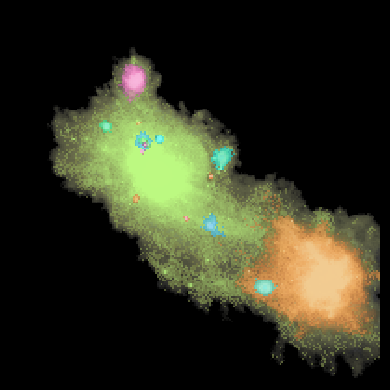

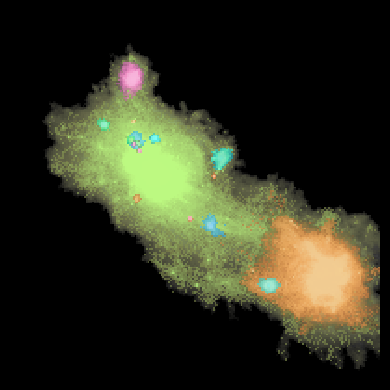

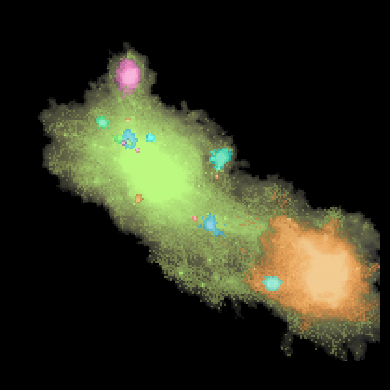

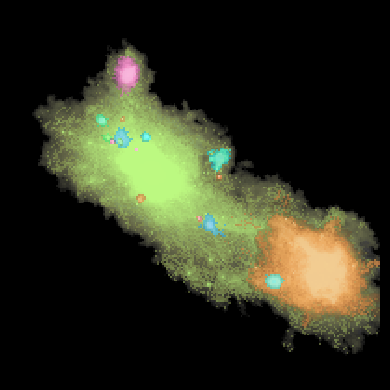

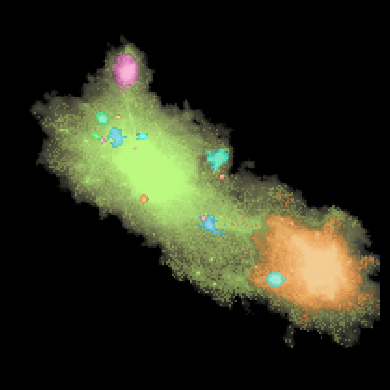

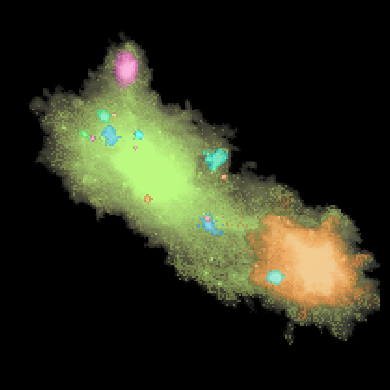

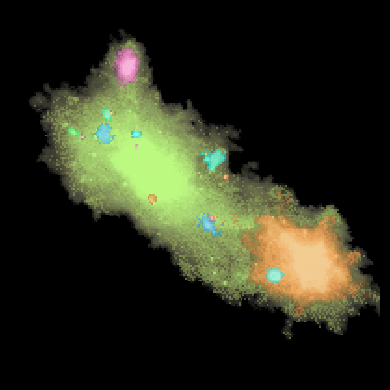

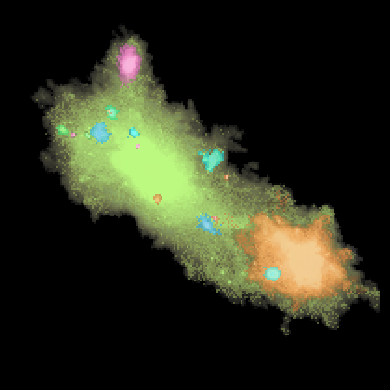

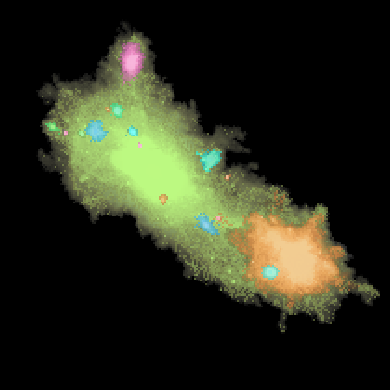

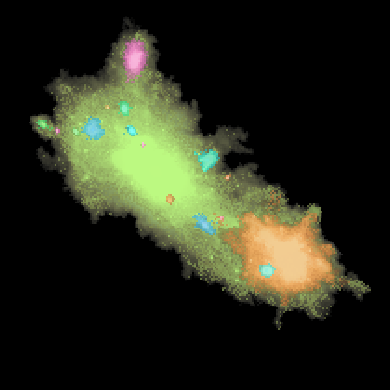

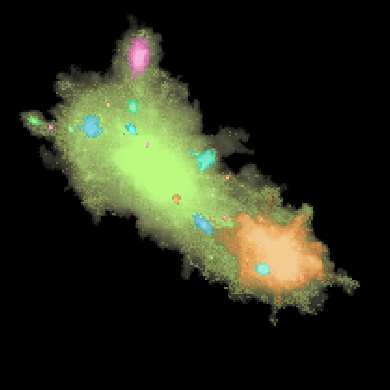

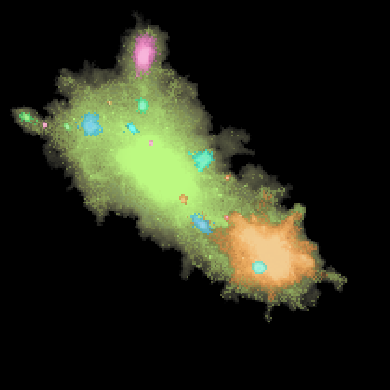

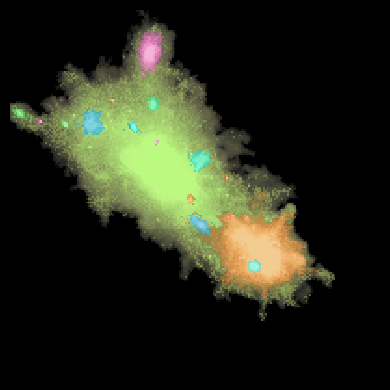

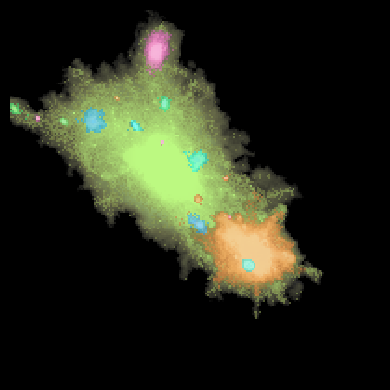

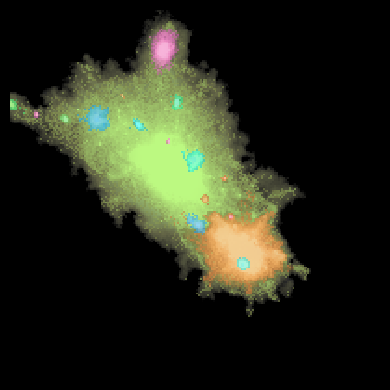

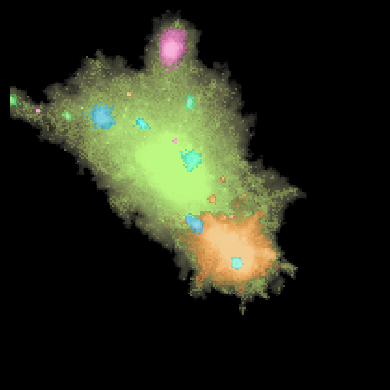

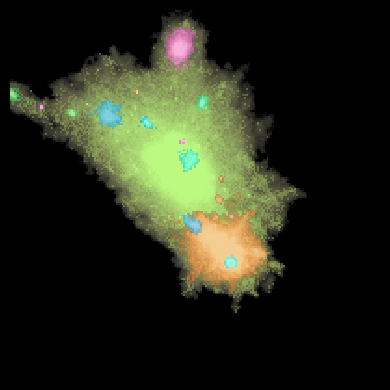

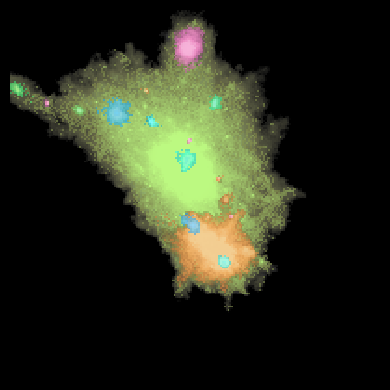

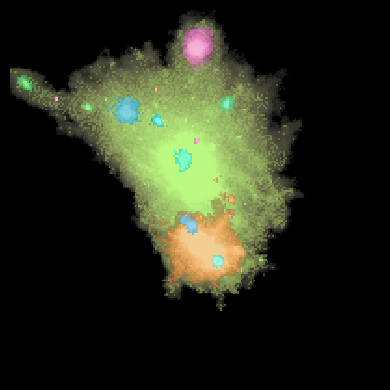

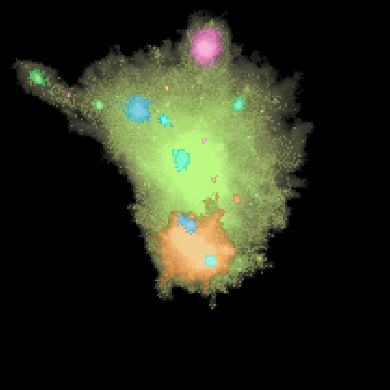

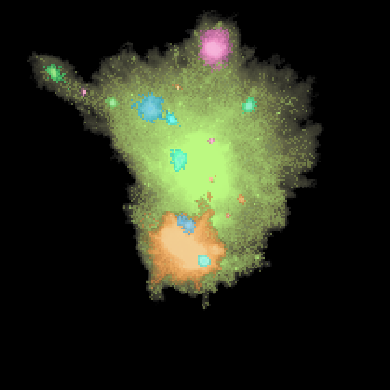

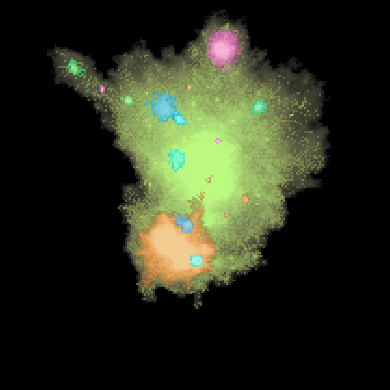

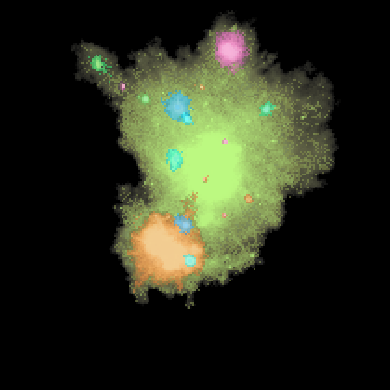

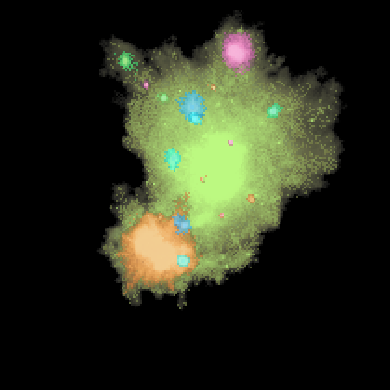

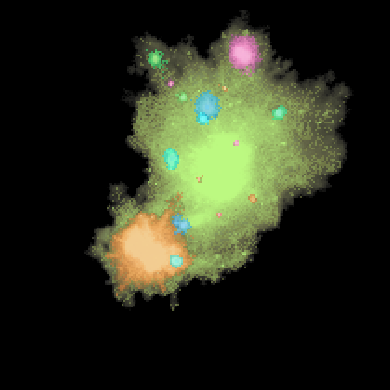

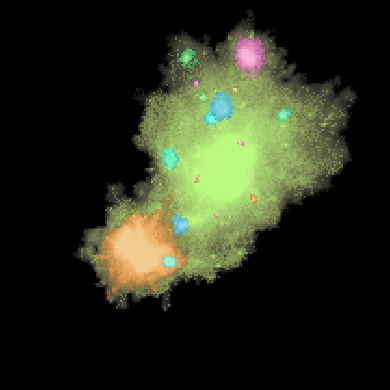

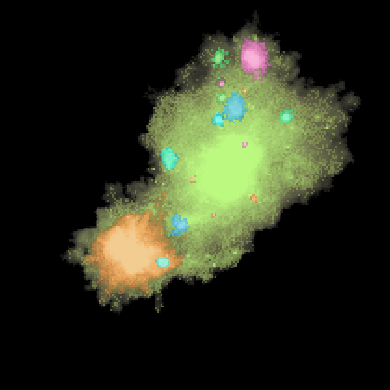

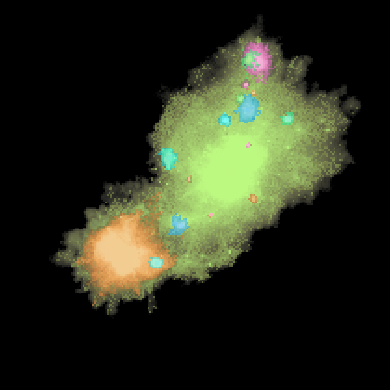

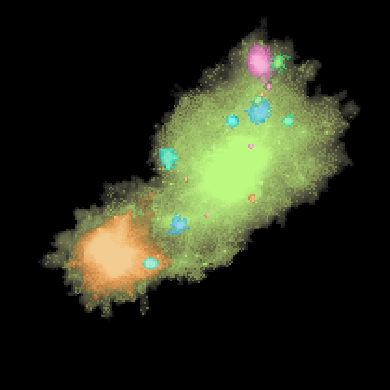

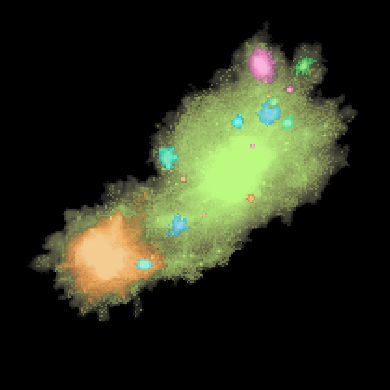

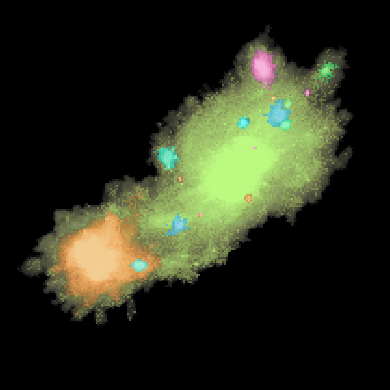

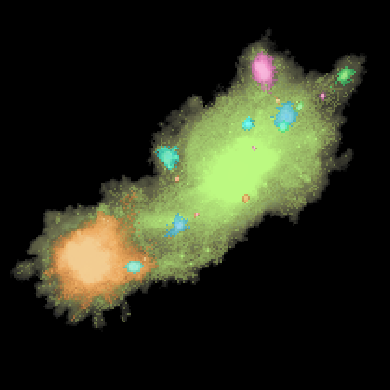

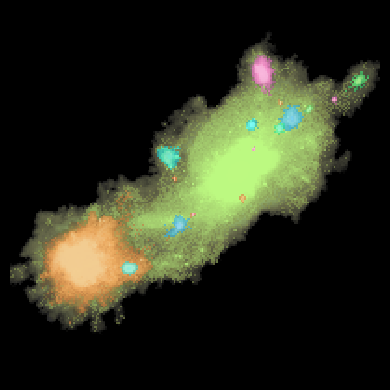

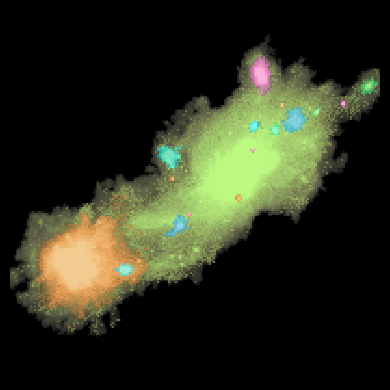

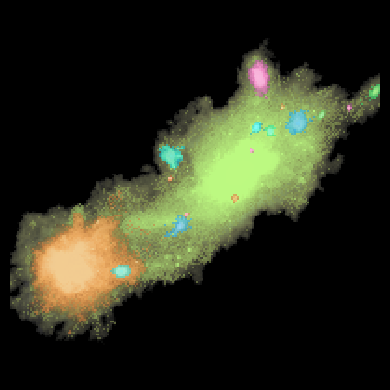

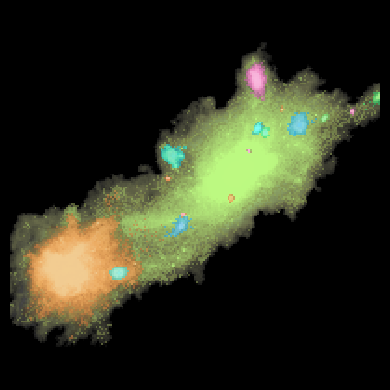

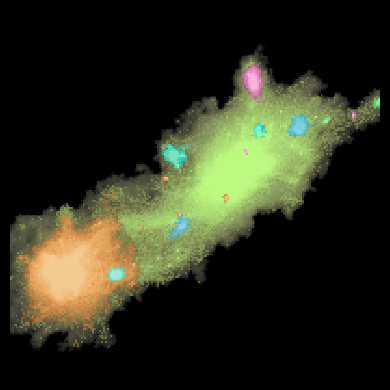

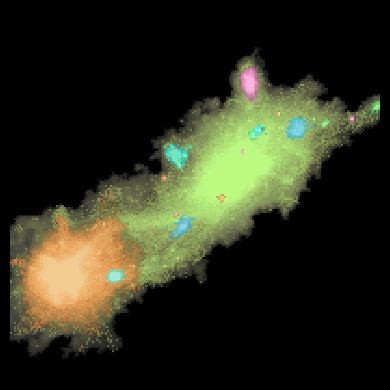

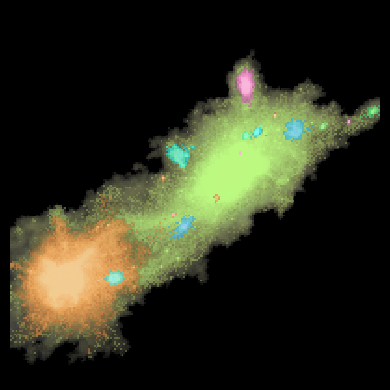

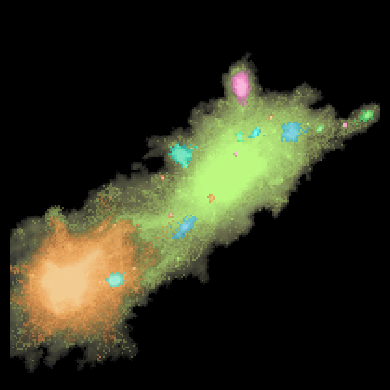

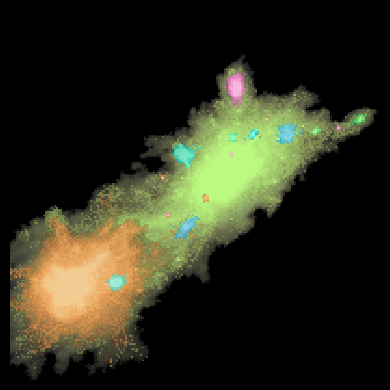

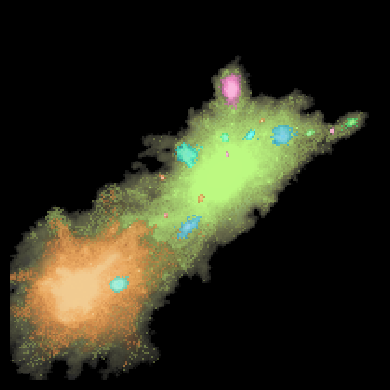

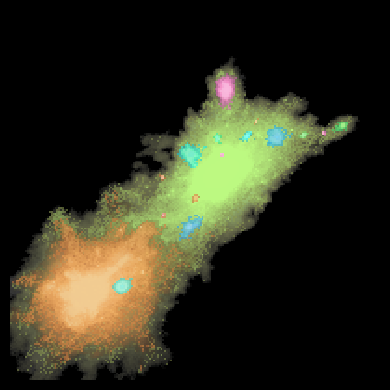

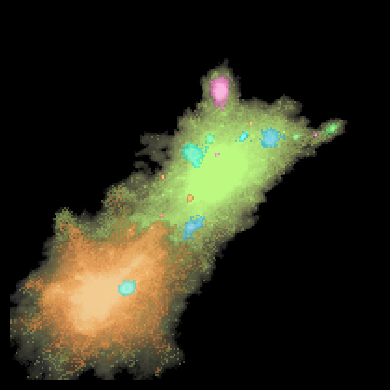

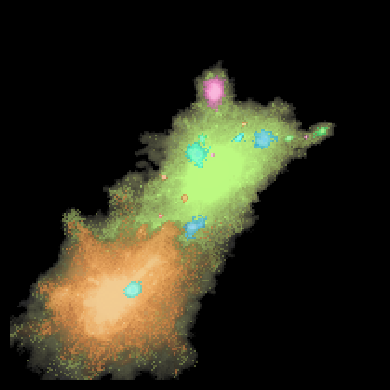

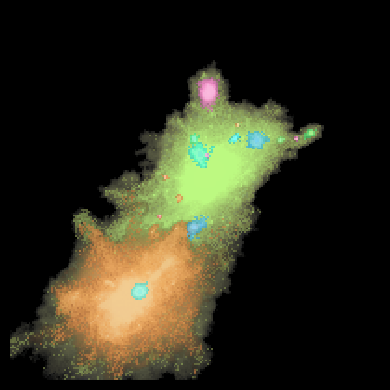

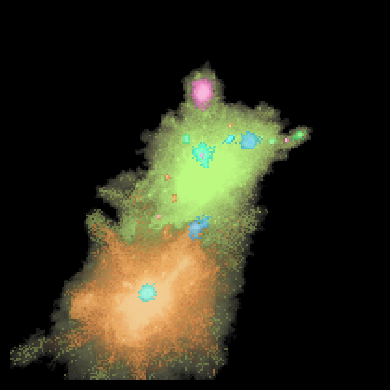

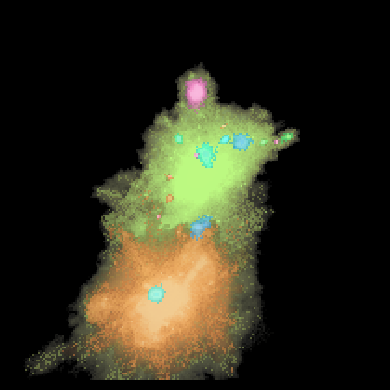

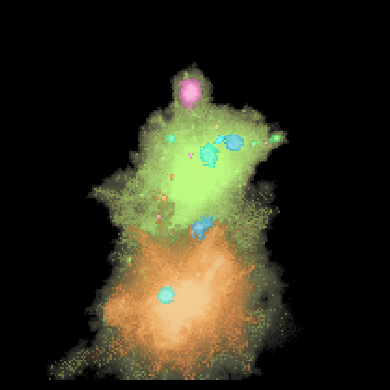

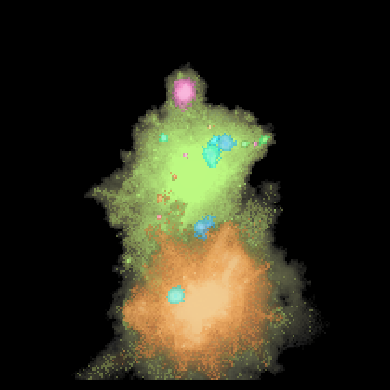

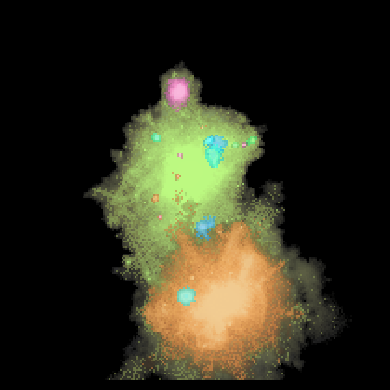

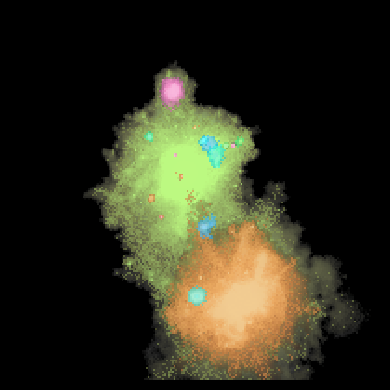

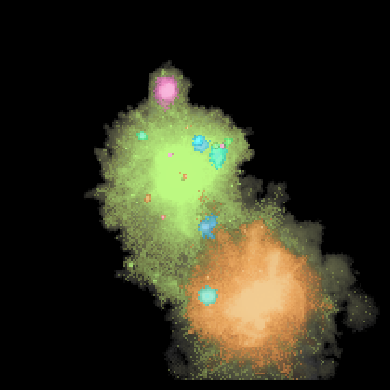

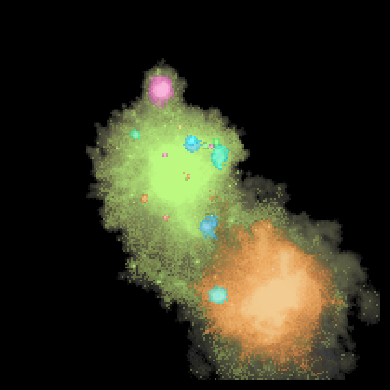

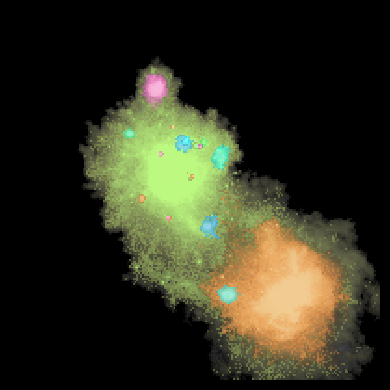

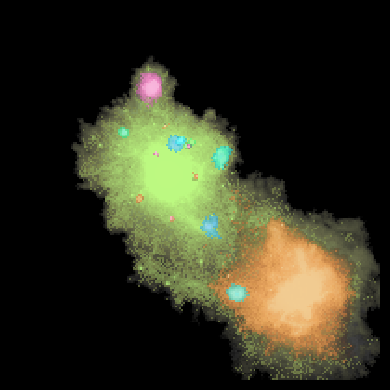

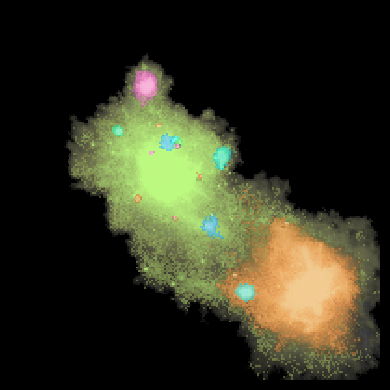

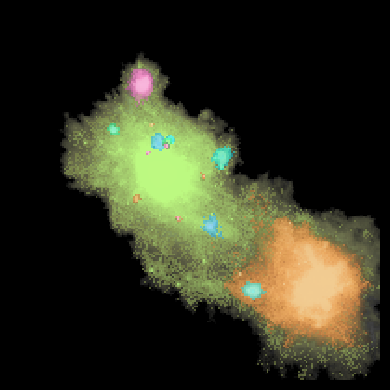

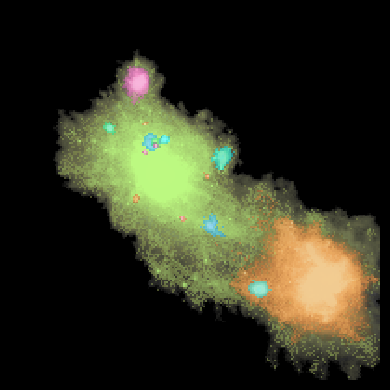

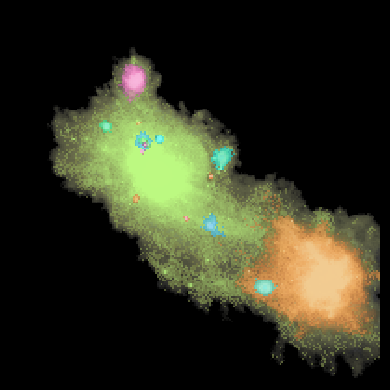

In [118]:
for (i, theta) in enumerate(np.linspace(0, 2*np.pi, 60)):
    fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=100, facecolor='black')
    cos = np.cos(theta)
    sin = np.sin(theta)
    y = sin*gas_pos[:, X] + cos*gas_pos[:, Y] + y0
    hist, xedges, yedges, mesh = plt.hist2d(
                x=(cos*gas_pos[:, X] - sin*gas_pos[:, Y])/y, 
                y=gas_pos[:, Z]/y, 
                bins=(edges, edges),
                weights=gas_mass.value,
                cmap='Greys_r',
                        norm=LogNorm(),
        alpha=0.5,

    )
    plt.axis('off')
    j = 0
    for id in subhalo_id:
        gas_select = gas_subhalo_id == id
        if np.sum(gas_select) > 2:
            cmap = fade_cmaps[j % len(fade_cmaps)]
            j += 1
            y = sin*gas_pos[gas_select, X] + cos*gas_pos[gas_select, Y] + y0
            plt.hist2d(
                x=(cos*gas_pos[gas_select, X] - sin*gas_pos[gas_select, Y])/y, 
                y=(gas_pos[gas_select, Z])/y, 
                bins=(edges, edges), 
                weights=gas_mass[gas_select].value,
                cmap=cmap,
                norm=LogNorm(vmin=1e37, vmax=1e41),
            )
            star_select = star_subhalo_id == id
            if np.sum(star_select) > 2:
                y = sin*star_pos[star_select, X] + cos*star_pos[star_select, Y] + y0
                plt.hist2d(
                    x=(cos*star_pos[star_select, X] - sin*star_pos[star_select, Y])/y, 
                    y=star_pos[star_select, Z]/y, 
                    bins=(xedges, yedges),
                    norm=LogNorm(vmin=1e33, vmax=1e39),
                    weights=star_mass[star_select], 
                    cmap=cmap,
                )
    
    plt.tight_layout()
    plt.savefig(f'vis/halo_{halo_id}/{i:02}.png')
    plt.show()
    plt.clf()
    plt.close('all')